#**Head Pose Estimation**

- In this project we will draw the 3 position axis (pitch,yaw,roll) by predicting the 3 angels of each position by training 3 models to predict each angel. 
- We will use [AFLW2000](http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip) dataset with contains 2000 image and 2000 matlab file with contains the 3 labels (angels).
- We will use MediaPipe library in both training and testing phases:
  - In Training: first we dtect the face of each image then using the same library to generate the landmark points of the face after this phase the training data (features) will contain 1853 samples with 936 columns (468 for X and 468 for Y), for labels we will extract the 3 angels from the mat file. 
  - In Testing: we will use the MediaPipe Library to generate the landmarks as we did in the training phase and using the trained models to predict the 3 labels and using them to draw the axis.  

### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Importing Libraries

In [38]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score,GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from google.colab.patches import cv2_imshow

### Loading Data

In [3]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

### Preparing Data for Training

In [4]:
# X_points, Y_points, labels and detected files which are the images thar MediaPipe was able to detect the face  
X_points = []
Y_points = []
labels = []
detected_files = []

# extracting the file names (2000 name)
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])

# detecting faces and extracting the points
faceModule = mediapipe.solutions.face_mesh
# looping over the file names to load the images and their corresponding mat file
for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the 468 points of x and y
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # X_features
              X.append(relative_x)
              # Y_features
              Y.append(relative_y)

          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image points
          X_points.append(X)
          Y_points.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

# converting features and labels to 2D array
X_points = np.array(X_points)
Y_points = np.array(Y_points)
labels = np.array(labels)

# the first label (pitch)
pitch_label = labels[:,0]
# the first label (yaw)
yaw_label = labels[:,1]
# the first label (roll)
roll_label = labels[:,2]
print(X_points.shape)
print(Y_points.shape)
print(labels.shape)

(1853, 468)
(1853, 468)
(1853, 3)


### Preprocessing the data

In [5]:
# center 99
# max = 10
# min = 171
# centering the data arround the 99th point 
Center_X = X_points - X_points[:,99].reshape(-1,1)
Center_Y = Y_points - Y_points[:,99].reshape(-1,1)

# normalizing the data to be in the same scale by dividing over the distance between point 10 and point 171
X_171 = X_points[:,171]
X_10 = X_points[:,10]
Y_171 = Y_points[:,171]
Y_10 = Y_points[:,10]
# computing the distance
distance = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
Norm_X = Center_X / distance
Norm_Y = Center_Y / distance

# if you want to choose specific columns from the data
Final_X = Norm_X
Final_Y = Norm_Y

print(Final_X.shape)
print(Final_Y.shape)

# concatinating the X and Y points to form the compelete features
features = np.hstack([Final_X,Final_Y])
print(features.shape)

(1853, 468)
(1853, 468)
(1853, 936)


### Applying Cross Validation on models

In [ ]:
# xgboost regressor cross val
pitch_model = XGBRegressor(verbosity = 0)
yaw_model = XGBRegressor(verbosity = 0)
roll_model = XGBRegressor(verbosity = 0)
pitch_crossval = cross_val_score(pitch_model,features,pitch_label,scoring="neg_mean_absolute_error")
yaw_crossval = cross_val_score(roll_model,features,roll_label,scoring="neg_mean_absolute_error")
roll_crossval = cross_val_score(yaw_model,features,yaw_label,scoring="neg_mean_absolute_error") 

print(pitch_crossval)
print(yaw_crossval)
print(roll_crossval)
# computing the mean
print(pitch_crossval.mean())
print(yaw_crossval.mean())
print(roll_crossval.mean())

[-0.17437726 -0.07866154 -0.12215745 -0.13985495 -0.12734324]
[-0.12356691 -0.04613395 -0.08485527 -0.11572249 -0.10174358]
[-0.1014985  -0.05949036 -0.08305039 -0.09671772 -0.09058931]
-0.1284788866082601
-0.0944044391427354
-0.08626925563107453


In [ ]:
# RandomForestRegressor cross val
pitch_model = RandomForestRegressor()
yaw_model = RandomForestRegressor()
roll_model = RandomForestRegressor()
pitch_crossval = cross_val_score(pitch_model,features,pitch_label,scoring="neg_mean_absolute_error")
yaw_crossval = cross_val_score(roll_model,features,roll_label,scoring="neg_mean_absolute_error")
roll_crossval = cross_val_score(yaw_model,features,yaw_label,scoring="neg_mean_absolute_error") 

print(pitch_crossval)
print(yaw_crossval)
print(roll_crossval)
# computing the mean
print(pitch_crossval.mean())
print(yaw_crossval.mean())
print(roll_crossval.mean())

[-0.17079203 -0.0717809  -0.12213063 -0.15214609 -0.12577882]
[-0.16169634 -0.04648478 -0.09033608 -0.11663921 -0.09219189]
[-0.09373899 -0.06042144 -0.08092229 -0.09437692 -0.09472294]
-0.1285256922914637
-0.10146966038036767
-0.0848365185128575


In [ ]:
# SVR cross val
pitch_model = SVR()
yaw_model = SVR()
roll_model = SVR()
pitch_crossval = cross_val_score(pitch_model,features,pitch_label,scoring="neg_mean_absolute_error")
yaw_crossval = cross_val_score(roll_model,features,roll_label,scoring="neg_mean_absolute_error")
roll_crossval = cross_val_score(yaw_model,features,yaw_label,scoring="neg_mean_absolute_error") 

print(pitch_crossval)
print(yaw_crossval)
print(roll_crossval)
# computing the mean
print(pitch_crossval.mean())
print(yaw_crossval.mean())
print(roll_crossval.mean())

[-0.10270334 -0.06951141 -0.10286659 -0.12895237 -0.11841781]
[-0.08201628 -0.04474309 -0.07282968 -0.10860828 -0.09397576]
[-0.08177538 -0.04944059 -0.07510918 -0.08621725 -0.08657821]
-0.10449030551876552
-0.08043461811378826
-0.07582412257741089


### Splitting the data for training the model and validation

In [6]:
# splitting the data
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val,file_train,file_test = train_test_split(features,labels,detected_files,test_size = 0.2,random_state = 20)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

### GridSearch for XGBoostRegressor models

In [ ]:
xg_parameters = {'n_estimators': np.arange(7,15,2),'max_depth': np.arange(1,10,2),'learning_rate': np.arange(0.5,1,0.2)}
# grid search pitch
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_pitch = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_pitch.fit(X_train, y_train_pitch)
xg_winner_pitch = xg_gs_pitch.best_estimator_
print("Pitch Winner Model: ",xg_winner_pitch)
print("Train Error: ",mean_absolute_error(xg_winner_pitch.predict(X_train),y_train_pitch))
print("Validation Error: ",mean_absolute_error(xg_winner_pitch.predict(X_val),y_val_pitch))

Pitch Winner Model:  XGBRegressor(learning_rate=0.8999999999999999, max_depth=1, n_estimators=13,
             verbosity=0)
Train Error:  0.12161729844072713
Validation Error:  0.15801939375778895


In [ ]:
# grid search yaw
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_yaw = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_yaw.fit(X_train, y_train_yaw)
xg_winner_yaw = xg_gs_yaw.best_estimator_
print("Yaw Winner Model: ",xg_winner_yaw)
print("Train Error: ",mean_absolute_error(xg_winner_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",mean_absolute_error(xg_winner_yaw.predict(X_val),y_val_yaw))

Yaw Winner Model:  XGBRegressor(learning_rate=0.5, max_depth=5, n_estimators=7, verbosity=0)
Train Error:  0.054236402385155764
Validation Error:  0.09444332542337196


In [ ]:
# grid search roll
xg = XGBRegressor(random_state=0,verbosity = 0)
xg_gs_roll = GridSearchCV(estimator = xg,param_grid = xg_parameters)
xg_gs_roll.fit(X_train, y_train_roll)
xg_winner_roll = xg_gs_roll.best_estimator_
print("Yaw Winner Model: ",xg_winner_roll)
print("Train Error: ",mean_absolute_error(xg_winner_roll.predict(X_train),y_train_roll))
print("Validation Error: ",mean_absolute_error(xg_winner_roll.predict(X_val),y_val_roll))

Yaw Winner Model:  XGBRegressor(learning_rate=0.5, max_depth=1, n_estimators=9, verbosity=0)
Train Error:  0.10835984985581051
Validation Error:  0.1533696710441065


### GridSearch for SVR models

In [7]:
svr_parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}
# grid search pitch
svr = SVR()
svr_gs_pitch = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_pitch.fit(X_train, y_train_pitch)
svr_winner_pitch = svr_gs_pitch.best_estimator_
print("Pitch Winner Model: ",svr_winner_pitch)
print("Train Error: ",mean_absolute_error(svr_winner_pitch.predict(X_train),y_train_pitch))
print("Validation Error: ",mean_absolute_error(svr_winner_pitch.predict(X_val),y_val_pitch))

Pitch Winner Model:  SVR(C=100, kernel='poly')
Train Error:  0.09066986712801713
Validation Error:  0.09771672484590896


In [8]:
# grid search yaw
svr = SVR()
svr_gs_yaw = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_yaw.fit(X_train, y_train_yaw)
svr_winner_yaw = svr_gs_yaw.best_estimator_
print("Yaw Winner Model: ",svr_winner_yaw)
print("Train Error: ",mean_absolute_error(svr_winner_yaw.predict(X_train),y_train_yaw))
print("Validation Error: ",mean_absolute_error(svr_winner_yaw.predict(X_val),y_val_yaw))

Yaw Winner Model:  SVR(C=100, kernel='poly')
Train Error:  0.0683403243114337
Validation Error:  0.07244727944220614


In [9]:
# grid search roll
svr = SVR()
svr_gs_roll = GridSearchCV(estimator = svr,param_grid = svr_parameters)
svr_gs_roll.fit(X_train, y_train_roll)
svr_winner_roll = svr_gs_roll.best_estimator_
print("Yaw Winner Model: ",svr_winner_roll)
print("Train Error: ",mean_absolute_error(svr_winner_roll.predict(X_train),y_train_roll))
print("Validation Error: ",mean_absolute_error(svr_winner_roll.predict(X_val),y_val_roll))

Yaw Winner Model:  SVR(C=10)
Train Error:  0.07648554697691795
Validation Error:  0.07851113595913625


### Defining function for drawing the 3 axis

In [10]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Visualing Random image and drawing its points and axis

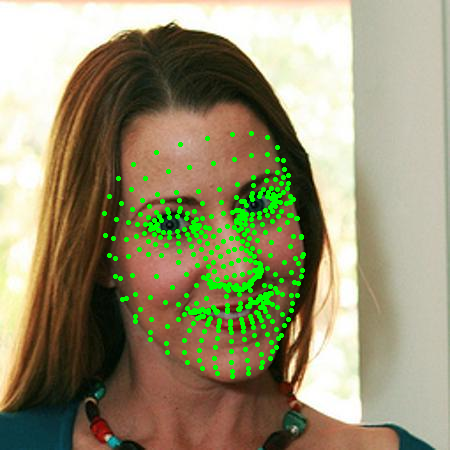

In [14]:
# choosing random image from the testing data
image_name = random.choice(file_test)
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # 
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            #cv2.putText(frame, str(j), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 2)
    cv2_imshow(frame)

### Drawing the axis from the true labels on the image

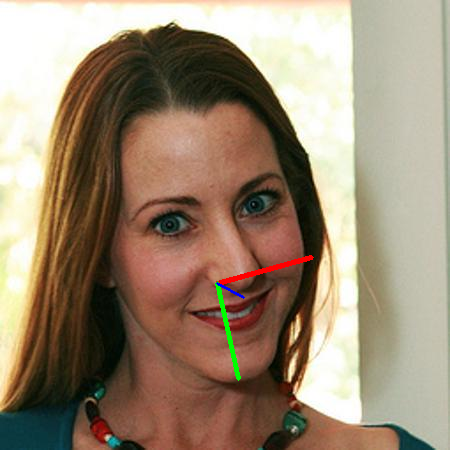

In [15]:
# reading the image
frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
# reading the true labels and drawing the axis on the image
mat = sio.loadmat('/content/AFLW2000/' + image_name + '.mat')
pitch_true = mat["Pose_Para"][0][0]
yaw_true = mat["Pose_Para"][0][1]
roll_true = mat["Pose_Para"][0][2]
cv2_imshow(draw_axis(frame,pitch_true,yaw_true,roll_true,X[99],Y[99]))

### Testing the model on the image

We can choose any one from svr or xgboost to process the video

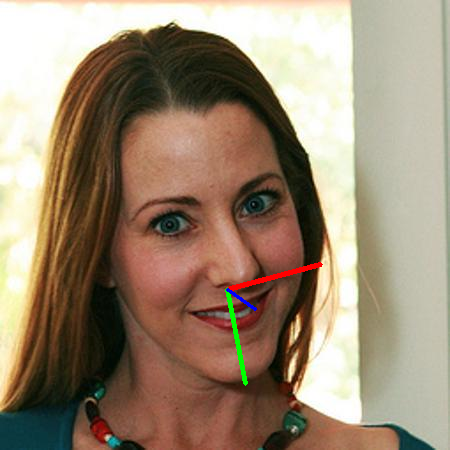

In [16]:
# choosing random image from the testing data
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # appending the points to the X and Y lists
            X.append(relative_x)
            Y.append(relative_y)

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 99
        X_center = X - X[99]
        Y_center = Y - Y[99]
        # computing the distance between the point 171 and 10
        d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
        # normalizing the points
        X_norm = X_center/d
        Y_norm = Y_center/d
        X_norm = X_norm
        Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = svr_winner_pitch.predict(points)
        pred_yaw = svr_winner_yaw.predict(points)
        pred_roll = svr_winner_roll.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99]))

In [26]:
# loading the test video
%%capture
!git clone https://github.com/MarwanMohamed95/Head-Pose-Estimation

### Implementing Queue for storing the angles

- Here we will store the angels upto the maximum size we would define to get the average of them for smoothing the moving of the axis.

In [36]:
class Queue:
    # defining the constructor
    def __init__(self,max_size):
        self.queue = []
        self.length = 0
        self.max_size = max_size
    
    # adding values to the queue
    def enqueue(self,x):
        if self.length < self.max_size:
          self.queue.append(x)
          self.length = self.length+1
        else:
          print("You have reached the maximum size") 
    # removing values from the queue
    def dequeue(self):
        if len(self.queue) > 0:
            removed = self.queue[0]
            del self.queue[0]
            self.length = self.length-1
            return removed
        else:
            print("Queue is Empty")

    # checking if the queue is full
    def IsFull(self):
      if self.length == self.max_size:
        return True
    
    # printing the queue values
    def print_queue(self):
        for i in self.queue:
            print(i)

### Testing the model on a video by processing its frames and drawing the axis on them

In [29]:
# Create a VideoCapture object and read from input file
def Create_TestVideo(pitch_model,yaw_model,roll_model,smoothing = False,size = 30):

  cap = cv2.VideoCapture('/content/Head-Pose-Estimation/test.mp4')
  width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Check if camera opened successfully
  if (cap.isOpened()== False): 
      print("Error opening video file")

  
  pitch_queue = Queue(max_size = size)
  yaw_queue = Queue(max_size = size)
  roll_queue = Queue(max_size = size)

  # initializing a list to store the frames   
  img_array = []
  # Read until video is completed
  while(cap.isOpened()):   
    # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        with faceModule.FaceMesh(static_image_mode=True) as face:
          # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
          results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                # initializing X and Y lists to store the spacial coordinates of the points
                X = []
                Y = []
                # looping over the landmarks to extract x and y
                for j,landmark in enumerate(face.landmark):
                    x = landmark.x
                    y = landmark.y
                    # retrieve the true values of x and y
                    shape = frame.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    X.append(relative_x)
                    Y.append(relative_y)

                X = np.array(X)
                Y = np.array(Y)
                # centering the data arround the point 99
                X_center = X - X[99]
                Y_center = Y - Y[99]
                d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
                X_norm = X_center/d
                Y_norm = Y_center/d
                X_norm = X_norm
                Y_norm = Y_norm
                points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
                # predicting the 3 angels to draw the axis on the image
                pred_pitch = pitch_model.predict(points)
                pred_yaw = yaw_model.predict(points)
                pred_roll = roll_model.predict(points)
                
                if smoothing  == True:
                  if not pitch_queue.IsFull(): 
                    pitch_queue.enqueue(pred_pitch)
                    yaw_queue.enqueue(pred_yaw)
                    roll_queue.enqueue(pred_roll)
                  else:
                    pitch_queue.dequeue()
                    yaw_queue.dequeue()
                    roll_queue.dequeue()
                    pitch_queue.enqueue(pred_pitch)
                    yaw_queue.enqueue(pred_yaw)
                    roll_queue.enqueue(pred_roll)

                  pitch = sum(pitch_queue.queue)/len(pitch_queue.queue)
                  yaw = sum(yaw_queue.queue)/len(yaw_queue.queue)
                  roll = sum(roll_queue.queue)/len(roll_queue.queue)
                  draw_axis(frame,pitch,yaw,roll,X[1],Y[1])

                else:
                  draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[1],Y[1])
                # appending the result frame to the img_array list
                img_array.append(frame)
      # Break the loop
      else: 
          break
  cap.release()  
  # Closes all the frames
  cv2.destroyAllWindows()
  print("Number of Detected Frames = ",len(img_array))
  # converting the frames to video
  out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
  for i in range(len(img_array)):
    out.write(img_array[i])
  out.release()

In [34]:
Create_TestVideo(svr_winner_pitch,svr_winner_yaw,svr_winner_roll,smoothing = True,size = 25)

Number of Detected Frames =  662


In [35]:
from google.colab import files
files.download('/content/out.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We can concolude at the end that SVR and XGboostRegressor trained well on the data and worked well also on testing phase on the video